In [1]:
import tensorflow as tf

In [2]:
import zipfile
import os
import tensorflow as tf


In [3]:
# Specify the path to the ZIP file and the destination folder
# zip_file_path = r"C:\Users\LENOVO\Desktop\archive.zip"
extract_folder = r"C:\Users\LENOVO\Desktop\extracted_files"

# Create the destination folder if it doesn't exist
# os.makedirs(extract_folder, exist_ok=True)

# # Extract the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder)


In [4]:
# Specify the path to the extracted dataset
dataset_path = os.path.join(extract_folder, "Indian Medicinal Leaves Image Datasets/Medicinal plant dataset")

# Create the dataset using image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    batch_size=32,
    image_size=(299, 299),
)

# Get the class names (labels)
labels = dataset.class_names
print(labels)


Found 5979 files belonging to 40 classes.
['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Ashoka', 'Ashwagandha', 'Avacado', 'Bamboo', 'Basale', 'Betel', 'Betel_Nut', 'Brahmi', 'Castor', 'Curry', 'Ekka', 'Ganike', 'Geranium', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Indian_Borage', 'Insulin', 'Jasmine', 'Lemon', 'Lemon_grass', 'Mango', 'Mint', 'Nagadali', 'Neem', 'Nithyapushpa', 'Nooni', 'Papaya', 'Pepper', 'Pomegranate', 'Raktachandini', 'Rose', 'Sapota', 'Tulsi', 'Wood_sorel']


In [5]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 299, 299, 3)
[16 23 20 26 38 25  0 26 37 16 18 25 35 29 12 38 11 33 36 37 25  4  9 25
 33 39 27  9 16 17  4 34]


In [6]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size, test_size

(149, 37)

In [7]:
def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [8]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(149, 37, 1)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(299, 299),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [10]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

In [11]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(299, 299, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=20
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                5160      
                                                                 
Total params: 22070216 (84.19 MB)
Trainable params: 267432 (

In [12]:
model.save(r"c:\Users\LENOVO\Desktop\modelv2.h5")

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model_path = r"c:\Users\LENOVO\Desktop\modelv2.h5"  # Specify the local path to your saved model file

# Load the model from the specified local path
model = tf.keras.models.load_model(model_path)


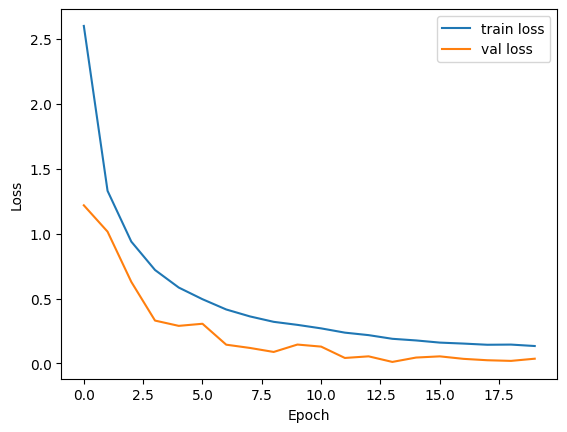

<Figure size 640x480 with 0 Axes>

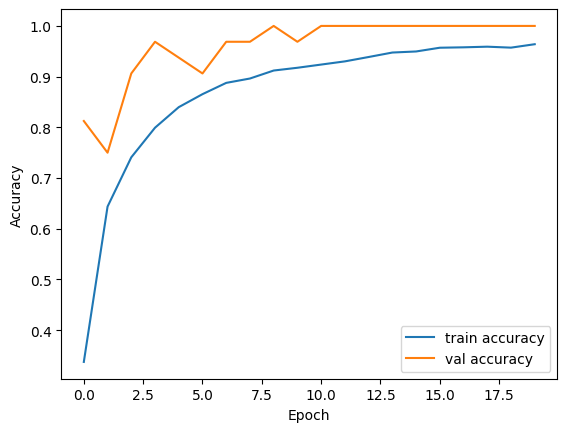

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(history, metric, save_path):
    """
    Plots a given metric (e.g. loss, accuracy) from the training history.
    
    Parameters:
    history (tf.keras.callbacks.History): Training history object returned by model.fit().
    metric (str): The name of the metric to plot ('loss' or 'accuracy').
    save_path (str): File path where the plot will be saved.
    """
    plt.figure()
    plt.plot(history.history[metric], label=f'train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'val {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()
    plt.savefig(save_path)

# Plot and save the loss and accuracy graphs
plot_metrics(history, 'loss', 'LossVal_loss.png')
plot_metrics(history, 'accuracy', 'AccVal_acc.png')